<a href="https://colab.research.google.com/github/hamojb/AD_research/blob/main/AD_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Notebook

## Contents

1. Helper Functions 

2. Data Exploration

3. Patient Data Cleaning and Manipulation 

4. Reading Scans

5. Build Model Architecture

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
!pip install transformers 

     |████████████████████████████████| 2.9 MB 6.7 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 636 kB 74.5 MB/s 
     |████████████████████████████████| 895 kB 93.4 MB/s 
     |████████████████████████████████| 3.3 MB 73.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from nibabel.testing import data_path
import tensorflow as tf
import nibabel as nib
import os, psutil
from collections import Counter
import nibabel as nib
from scipy import ndimage
from tqdm.notebook import tqdm, trange
import time
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import scale
import torch 
from torch.utils.data import TensorDataset, DataLoader
from transformers import DeiTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F
from transformers import DeiTFeatureExtractor
import torch.nn as nn
import torch
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from psutil import virtual_memory
from random import shuffle

Get information about the GPU and RAM in the current runtime. 

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Oct 12 22:58:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Helper Functions 

In [6]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 224
    desired_width = 224
    desired_height = 224
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def crop(img):
    blank_val = img[0].sum()
    x = [] 
    for i in range(len(img)): 
      if img[i,:,:].sum() != blank_val: 
        x.append(i)
    y = [] 
    for i in range(len(img)): 
      if img[i,:,:].sum() != blank_val: 
        y.append(i)
    z = [] 
    for i in range(len(img)): 
      if img[i,:,:].sum() != blank_val: 
        z.append(i)
    img = np.squeeze(img[min(x):max(x), min(y):max(y), min(z):max(z)])

    # Set the desired depth
    desired_depth = 224
    desired_width = 224
    desired_height = 224
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    volume = tf.image.per_image_standardization(volume)
    volume = resize_volume(volume)
    volume = crop(volume)
    return volume

def show_slices(slices, col = None):
  """ Function to display row of image slices """
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap=col, origin="lower")
  return

def match_data(scan_data, diagnosis_data): 
  empty_df = pd.DataFrame()
  scan_patients = list(set(scan_data.Subject.values))
  for patient in scan_patients:
    temp_scans = scan_data[scan_data['Subject'] == patient]
    temp_scans = temp_scans.sort_values('ID')
    temp_diag = diagnosis_data[diagnosis_data['Subject'] == patient]
    temp_diag = temp_diag.sort_values('ID')
    test = pd.merge_asof(temp_scans, temp_diag, on="ID", allow_exact_matches=True, direction = "forward")
    empty_df = empty_df.append(test)
  empty_df = empty_df.drop(columns = ['Inserted_x', 'Inserted_y', 'Subject_y', 'ageAtEntry'])
  empty_df = empty_df.rename(columns = {"Subject_x":"Subject","FS_FSDATA ID":"MRI_ID"})
  empty_df = empty_df.reset_index().drop(columns = ["index"])
  empty_df = empty_df.dropna()
  return empty_df

def return_scan_paths(data, data_def:str):
  cdr_HC = data[data['cdr'] == 'HC']
  cdr_MCI = data[data['cdr'] == 'MCI']
  cdr_AD = data[data['cdr'] == 'AD']

  HC_scan_paths = list(cdr_HC['MRI_ID'].values)
  MCI_scan_paths = list(cdr_MCI['MRI_ID'].values)
  AD_scan_paths = list(cdr_AD['MRI_ID'].values)

  print("MRI scans of AD cases in {} data: {}".format(data_def, str(len(AD_scan_paths))))
  print("MRI scans of MCI cases in {} data: {}".format(data_def, str(len(MCI_scan_paths))))
  print("MRI scans of HC cases in {} data: {}".format(data_def, str(len(HC_scan_paths))))
  return HC_scan_paths, MCI_scan_paths, AD_scan_paths

def split_HC(lst): 
  return lst[:int(len(lst) * 5)]

def return_labels(data):
  cdr_HC = data[data['cdr'] == 'HC']
  cdr_MCI = data[data['cdr'] == 'MCI']
  cdr_AD = data[data['cdr'] == 'AD']

  HC_labels = list(cdr_HC['cdr'].values)
  MCI_labels = list(cdr_MCI['cdr'].values)
  AD_labels = list(cdr_AD['cdr'].values)
  ydata = np.concatenate((HC_labels, MCI_labels, AD_labels))
  dummies = pd.get_dummies(ydata, columns=["Bridge_Types"], prefix=["Type_is"] )
  return HC_labels, MCI_labels, AD_labels

# Data Exploration

In [7]:
path = os.path.join("/drive/MyDrive/oasis_original/OAS30001_Freesurfer53_d0129.mgz.nii.gz")
img = nib.load(path)
data = img.get_fdata()

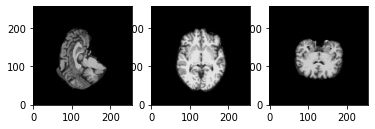

In [8]:
slice_0 = data[128, :, :]
slice_1 = data[:, 128, :]
slice_2 = data[:, :, 128]
show_slices([slice_0, slice_1, slice_2], "gray")

# Read Clinical Data

This data contains the associated CDR score for each scan. During this cleaning process we deal with the following issues: 

- The 'day' of diagnosis does not match the 'day' of the scan. We deal with this by making the assumption that the first CDR score (closest match watch with CDR days > scan days) after the scan is the true diagnoses. 
- Patients may have mutliple scans (lonitudinal data). This is dealt with by splitting the training/validation/test sets on the patient ID rather than the scan itself. This is to ensure that we are not training on the same patient's scan that will later be used for testing. 

In [9]:
clinical_data = pd.read_csv("/drive/MyDrive/extra_data/clinical_data.csv")
clinical_data['ID'] = clinical_data['ADRC_ADRCCLINICALDATA ID'].str.split('_ClinicalData_', 1, expand=True)[1]
clinical_data = clinical_data.drop(columns = ['ADRC_ADRCCLINICALDATA ID', 'Date', 'Subject.1', 'id'])
clinical_data['Inserted'] = pd.to_datetime(clinical_data['Inserted'])
clinical_data['ID'] = clinical_data['ID'].str.extract('(\d+)', expand=False).astype(int)
clinical_data

,Subject,ageAtEntry,cdr,Inserted,ID
0,OAS30001,65.149895,0.0,2017-12-20 10:54:32.956,0
1,OAS30001,65.149895,0.0,2017-12-20 10:54:33.466,339
2,OAS30001,65.149895,0.0,2017-12-20 10:54:33.673,722
3,OAS30001,65.149895,0.0,2017-12-20 10:54:33.891,1106
4,OAS30001,65.149895,0.0,2017-12-20 10:54:34.117,1456
...,...,...,...,...,...
6219,OAS31172,70.902120,0.0,2017-12-20 14:50:44.860,1215
6220,OAS31172,70.902120,0.0,2017-12-20 14:50:45.131,1565
6221,OAS31172,70.902120,0.0,2017-12-20 14:50:45.404,1908
6222,OAS31172,70.902120,0.0,2017-12-20 14:50:45.679,2816


# Scan Information Data

In [10]:
scan_info = pd.read_csv("/drive/MyDrive/extra_data/freesurfers_mri_info.csv")
scan_info['ID'] = scan_info['FS_FSDATA ID'].str.split('_Freesurfer', 1, expand = True)[1]
scan_info = scan_info.drop(columns = ['Session', 'FS Date'])
scan_info.ID = scan_info.ID.str[3:]
scan_info['Inserted'] = pd.to_datetime(scan_info['Inserted'])
scan_info['ID'] = scan_info['ID'].str.extract('(\d+)', expand=False).astype(int)
scan_info

,FS_FSDATA ID,Subject,Inserted,ID
0,OAS30001_Freesurfer53_d0129,OAS30001,2017-11-15 13:26:34.150,129
1,OAS30001_Freesurfer53_d0757,OAS30001,2017-12-13 13:44:44.891,757
2,OAS30001_Freesurfer53_d2430,OAS30001,2017-11-15 11:10:13.939,2430
3,OAS30001_Freesurfer53_d3132,OAS30001,2017-10-20 12:44:27.928,3132
4,OAS30002_Freesurfer53_d0653,OAS30002,2017-11-10 12:45:42.205,653
...,...,...,...,...
2042,OAS31168_Freesurfer53_d2526,OAS31168,2017-11-09 14:22:52.248,2526
2043,OAS31169_Freesurfer53_d0620,OAS31169,2017-10-18 15:15:06.880,620
2044,OAS31170_Freesurfer53_d2410,OAS31170,2017-10-18 15:15:06.574,2410
2045,OAS31172_Freesurfer53_d0407,OAS31172,2017-10-18 15:15:06.817,407


# Combining Clinical and Scan Information Data

In [11]:
scan_and_diag = match_data(scan_info, clinical_data)
scans_sorted = scan_and_diag.sort_values(["Subject", "ID"]).reset_index().drop(columns = ["index", "ID"])
scans_sorted['cdr'] = scans_sorted['cdr'].astype(str).replace({'0.0':'HC', '0.5': 'MCI', '1.0': 'AD', '2.0': 'AD', '3.0': 'AD'})
scans_sorted

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,HC
1,OAS30001_Freesurfer53_d0757,OAS30001,HC
2,OAS30001_Freesurfer53_d2430,OAS30001,HC
3,OAS30001_Freesurfer53_d3132,OAS30001,HC
4,OAS30002_Freesurfer53_d0653,OAS30002,HC
...,...,...,...
1824,OAS31168_Freesurfer53_d2526,OAS31168,HC
1825,OAS31169_Freesurfer53_d0620,OAS31169,MCI
1826,OAS31170_Freesurfer53_d2410,OAS31170,AD
1827,OAS31172_Freesurfer53_d0407,OAS31172,HC


In [12]:
lst_scans = list(os.listdir(r'/drive/MyDrive/oasis_original/'))
our_scans =[] 
for i in lst_scans: 
  our_scans.append(i.split('.')[0])
our_scans[:5]

['OAS31054_Freesurfer53_d2787',
 'OAS31052_Freesurfer53_d0093',
 'OAS31056_Freesurfer53_d0100',
 'OAS31056_Freesurfer53_d0808',
 'OAS31056_Freesurfer53_d1912']

In [13]:
copy_scans_sorted = scans_sorted.copy()
copy_scans_sorted = copy_scans_sorted[copy_scans_sorted['MRI_ID'].isin(our_scans)]
copy_scans_sorted['MRI_ID'] = '/drive/MyDrive/oasis_original/' + copy_scans_sorted['MRI_ID'] + ".mgz.nii.gz"
cdr_HC = copy_scans_sorted[copy_scans_sorted['cdr'] == 'HC']
cdr_MCI = copy_scans_sorted[copy_scans_sorted['cdr'] == 'MCI']
cdr_AD = copy_scans_sorted[copy_scans_sorted['cdr'] == 'AD']

HC_scan_paths = list(cdr_HC['MRI_ID'].values)
MCI_scan_paths = list(cdr_MCI['MRI_ID'].values)
AD_scan_paths = list(cdr_AD['MRI_ID'].values)

print("MRI scans of AD cases: {}".format(str(len(AD_scan_paths))))
print("MRI scans of MCI cases: {}".format(str(len(MCI_scan_paths))))
print("MRI scans of HC cases: {}".format(str(len(HC_scan_paths))))

MRI scans of AD cases: 102
MRI scans of MCI cases: 266
MRI scans of HC cases: 1456


In [14]:
subj_ids = list(set(copy_scans_sorted["Subject"]))
shuffle(subj_ids)
print('There are {} patients in the data'.format(len(subj_ids)))

There are 937 patients in the data


In [15]:
train_num_subs = int(len(subj_ids)*.7)
valid_num_subs = int(len(subj_ids)*.15)
test_num_subs = int(len(subj_ids)*.15)
print("Desired training patients: {}".format(train_num_subs))
print("Desired validation patients: {}".format(valid_num_subs))
print("Desired test patients: {}".format(test_num_subs))

Desired training patients: 655
Desired validation patients: 140
Desired test patients: 140


In [16]:
ad_subjs = cdr_AD.Subject.values
use_this_val = len(list(set(ad_subjs)))
print('There are {} patients with AD, this value will be used to ensure that we always have\
 enough data across all dementia types'.format(use_this_val))

There are 95 patients with AD, this value will be used to ensure that we always have enough data across all dementia types


In [17]:
try: 
  training_data = pd.read_csv('/drive/MyDrive/new_data/training.csv')
  validation_data = pd.read_csv('/drive/MyDrive/new_data/val.csv')
  test_data = pd.read_csv('/drive/MyDrive/new_data/test.csv')
except:   
  training_subjs = list(ad_subjs[:int(use_this_val * 0.7)])
  validation_subjs = list(ad_subjs[int(use_this_val * 0.7):int(use_this_val * 0.85)])
  test_subjs = list(ad_subjs[int(use_this_val * 0.85):])
  union = list(set().union(training_subjs, validation_subjs, test_subjs)) 
  for i in subj_ids: 
    if i not in union: 
      if len(test_subjs) < test_num_subs: 
        test_subjs.append(i)
      elif len(validation_subjs) < valid_num_subs: 
        validation_subjs.append(i)
      else: 
        training_subjs.append(i)
      union.append(i)
  cdr_HC = copy_scans_sorted[copy_scans_sorted['cdr'] == 'HC']
  cdr_MCI = copy_scans_sorted[copy_scans_sorted['cdr'] == 'MCI']
  cdr_AD = copy_scans_sorted[copy_scans_sorted['cdr'] == 'AD']
  training_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(training_subjs)]
  validation_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(validation_subjs)]
  test_data = copy_scans_sorted[copy_scans_sorted['Subject'].isin(test_subjs)]
  training_data.to_csv('/drive/MyDrive/new_data/training.csv')
  validation_data.to_csv('/drive/MyDrive/new_data/val.csv')
  test_data.to_csv('/drive/MyDrive/new_data/test.csv')

In [18]:
SPLITS = 20

In [19]:
training_splits = np.array_split(training_data, SPLITS)
val_splits = np.array_split(validation_data, SPLITS)

In [7]:
class DeiTForImageClassification(nn.Module):
      def __init__(self, num_labels=3):
          super(DeiTForImageClassification, self).__init__()
          # self.deit = DeiTModel.from_pretrained('flozi00/alzheimer-deit-base-distilled')
          self.deit = DeiTModel.from_pretrained('facebook/deit-base-distilled-patch16-384')
          self.dropout = nn.Dropout(0.7)
          self.classifier = nn.Linear(self.deit.config.hidden_size, num_labels)
          self.num_labels = num_labels

      def forward(self, pixel_values, labels):
          outputs = self.deit(pixel_values=pixel_values)
          output = self.dropout(outputs.last_hidden_state[:,0])
          logits = self.classifier(output)

          loss = None
          if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
          if loss is not None:
            return logits, loss.item()
          else:
            return logits, None


In [21]:
import torch.utils.data as data

EPOCHS = 5
BATCH_SIZE = 1
LEARNING_RATE = 2e-5
full_ML_results = pd.DataFrame()
label_encoder = LabelEncoder()

for RUN in range(SPLITS): 
  print('For run {}, we have:'.format(RUN))
  train_HC, train_MCI, train_AD = return_scan_paths(training_splits[RUN], 'training')

  if len(train_AD) < 10: 
    temp = training_data[training_data['cdr'] == 'AD'].sample(10, random_state=6)
    training_splits[RUN] = pd.concat([training_splits[RUN], temp])
    train_HC, train_MCI, train_AD = return_scan_paths(training_splits[RUN], 'training')
  
  if len(train_MCI) < 10: 
    temp = training_data[training_data['cdr'] == 'MCI'].sample(10, random_state=6)
    training_splits[RUN] = pd.concat([training_splits[RUN], temp])
    train_HC, train_MCI, train_AD = return_scan_paths(training_splits[RUN], 'training')
  
  print('Loading the scans for the training data...')
  x_train = np.array([process_scan(path) for path in tqdm(train_HC)])
  x_train = np.concatenate((x_train, np.array([process_scan(path) for path in tqdm(train_MCI)])))
  x_train = np.concatenate((x_train, np.array([process_scan(path) for path in tqdm(train_AD)])))
  y_train_HC, y_train_MCI, y_train_AD = return_labels(training_splits[RUN])
  y_train = y_train_HC + y_train_MCI + y_train_AD

  val_HC, val_MCI, val_AD = return_scan_paths(val_splits[RUN], 'validation')

  if len(val_MCI) < 10: 
    temp = validation_data[validation_data['cdr'] == 'MCI'].sample(10, random_state=6)
    val_splits[RUN] = pd.concat([val_splits[RUN], temp])
    val_HC, val_MCI, val_AD = return_scan_paths(val_splits[RUN], 'validation')
  
  if len(val_AD) < 10: 
    temp = validation_data[validation_data['cdr'] == 'AD'].sample(10, random_state=6)
    val_splits[RUN] = pd.concat([val_splits[RUN], temp])
    val_HC, val_MCI, val_AD = return_scan_paths(val_splits[RUN], 'validation')
  
  print('Loading the scans for the validation data...')
  x_val = np.array([process_scan(path) for path in tqdm(val_HC)])
  x_val = np.concatenate((x_val, np.array([process_scan(path) for path in tqdm(val_MCI)])))
  x_val = np.concatenate((x_val, np.array([process_scan(path) for path in tqdm(val_AD)])))
  y_val = return_labels(val_splits[RUN])
  y_val = [item for sublist in y_val for item in sublist]

  y_train = np.array(label_encoder.fit_transform(y_train))
  y_val = np.array(label_encoder.fit_transform(y_val))

  mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

  tens_x_train = torch.Tensor(x_train)
  tens_y_train = torch.Tensor(y_train)

  tens_x_val = torch.Tensor(x_val)
  tens_y_val = torch.Tensor(y_val)

  train_ds2 = TensorDataset(tens_x_train, tens_y_train)
  val_ds2 = TensorDataset(tens_x_val, tens_y_val)
  if RUN == 0: 
    model = DeiTForImageClassification(3)   
  else: 
    previous_model = 'transformer' + str(RUN-1)
    model = torch.load('/drive/MyDrive/models/'+previous_model+'.pt')
  feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-384')
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  loss_func = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
  if torch.cuda.is_available():
      model.cuda() 

  num_samples = len(y_train)
  counts = Counter(y_train)
  class_count = np.array([counts[0], counts[1], counts[2]])
  weights = 1./class_count
  samples_weight = np.array([weights[t] for t in y_train])
  samples_weight=torch.from_numpy(samples_weight)
  sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(train_ds2))

  print("Number of train samples: ", len(train_ds2))
  print("Number of validation samples: ", len(val_ds2))
  print('Classes are {}'.format(mapping))
  train_loader = data.DataLoader(train_ds2, batch_size=BATCH_SIZE, sampler = sampler, num_workers=1)
  val_loader  = data.DataLoader(val_ds2, batch_size=BATCH_SIZE, shuffle = True, num_workers=1) 
  results = pd.DataFrame()
  for epoch in range(EPOCHS):        
    print('Training EPOCH {} in RUN {}'.format(epoch+1, RUN))
    for step, (x, y) in enumerate(train_loader):    
      val = next(iter(val_loader))
      for index, array in enumerate(x):
        x[index] = np.squeeze(array)
      results_temp = pd.DataFrame()
      for slic in range(112-20,112+21):
        new_x = x[:,:,:,slic]
        new_x = Image.fromarray(np.array(new_x).astype('uint8'), 'RGB')
        new_x = torch.tensor(np.stack(feature_extractor(new_x)['pixel_values'], axis=0))
        new_x = transforms.ToPILImage()(np.squeeze(new_x)).convert()
        new_x = torch.tensor(np.stack(feature_extractor(new_x)['pixel_values'], axis=0))
        new_x, y  = new_x.to(device), y.to(device)
        b_x = Variable(new_x)   
        y = y.long()
        b_y = Variable(y)  
        output, loss = model(b_x, b_y)

        if loss is None: 
          loss = loss_func(output, b_y)   
          optimizer.zero_grad()           
          loss.backward()                 
          optimizer.step()

        val_x = val[0]

        for index, array in enumerate(val_x):
          val_x[index] = np.squeeze(array)

        new_val_x = val_x[:,:,:,slic]
        new_val_x = Image.fromarray(np.array(new_val_x).astype('uint8'), 'RGB')
        new_val_x = torch.tensor(np.stack(feature_extractor(new_val_x)['pixel_values'], axis=0))

        new_val_x = new_val_x.to(device)
        val_y = val[1].to(device).long()

        val_output, loss = model(new_val_x, val_y)
        pred = np.array(tf.nn.softmax(val_output.cpu().detach().numpy()))
        val_output = val_output.argmax(1)

        accuracy = (val_output == val_y).sum().item() / BATCH_SIZE
        # print("Prediction: {} Actual: {} Probabilities: {}".format(val_output.item(), val_y.item(), pred[0]))
        col_name_ad = str(slic) + 'AD'
        col_name_hc = str(slic) + 'HC'
        col_name_mci = str(slic) + 'MCI'

        temp_df = pd.DataFrame([pred[0]], columns =[col_name_ad, col_name_hc, col_name_mci], dtype = float)
        results_temp = pd.concat([results_temp, temp_df], axis = 1)

      actual_df = pd.DataFrame([val_y.item()], columns = ['Actual'])
      results_temp = pd.concat([results_temp, actual_df], axis = 1)
      results = pd.concat([results, results_temp])

  full_ML_results = pd.concat([full_ML_results, results])

  model_str = 'transformer' + str(RUN)
  torch.save(model, '/drive/MyDrive/models/'+model_str+'.pt')
  torch.cuda.empty_cache()

For run 0, we have:
MRI scans of AD cases in training data: 2
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 56
MRI scans of AD cases in training data: 12
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 56
MRI scans of AD cases in training data: 12
MRI scans of MCI cases in training data: 17
MRI scans of HC cases in training data: 56
Loading the scans for the training data...


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 2
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 14
Loading the scans for the validation data...


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-384 were not used when initializing DeiTModel: ['distillation_classifier.weight', 'cls_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['deit.pooler.dense.weight', 'deit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Number of train samples:  85
Number of validation samples:  36
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 0
Training EPOCH 2 in RUN 0
Training EPOCH 3 in RUN 0
Training EPOCH 4 in RUN 0
Training EPOCH 5 in RUN 0
For run 1, we have:
MRI scans of AD cases in training data: 3
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 13
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 13
MRI scans of MCI cases in training data: 19
MRI scans of HC cases in training data: 53
Loading the scans for the training data...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 2
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 14
Loading the scans for the validation data...


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  85
Number of validation samples:  36
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 1
Training EPOCH 2 in RUN 1
Training EPOCH 3 in RUN 1
Training EPOCH 4 in RUN 1
Training EPOCH 5 in RUN 1
For run 2, we have:
MRI scans of AD cases in training data: 4
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 18
MRI scans of HC cases in training data: 53
Loading the scans for the training data...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 2
MRI scans of HC cases in validation data: 13
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 13
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 13
Loading the scans for the validation data...


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  85
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 2
Training EPOCH 2 in RUN 2
Training EPOCH 3 in RUN 2
Training EPOCH 4 in RUN 2
Training EPOCH 5 in RUN 2
For run 3, we have:
MRI scans of AD cases in training data: 5
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 15
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 15
MRI scans of MCI cases in training data: 17
MRI scans of HC cases in training data: 52
Loading the scans for the training data...


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 0
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
Loading the scans for the validation data...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 3
Training EPOCH 2 in RUN 3
Training EPOCH 3 in RUN 3
Training EPOCH 4 in RUN 3
Training EPOCH 5 in RUN 3
For run 4, we have:
MRI scans of AD cases in training data: 6
MRI scans of MCI cases in training data: 15
MRI scans of HC cases in training data: 43
MRI scans of AD cases in training data: 16
MRI scans of MCI cases in training data: 15
MRI scans of HC cases in training data: 43
Loading the scans for the training data...


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 1
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 14
Loading the scans for the validation data...


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 4
Training EPOCH 2 in RUN 4
Training EPOCH 3 in RUN 4
Training EPOCH 4 in RUN 4
Training EPOCH 5 in RUN 4
For run 5, we have:
MRI scans of AD cases in training data: 6
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 51
MRI scans of AD cases in training data: 16
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 51
MRI scans of AD cases in training data: 16
MRI scans of MCI cases in training data: 17
MRI scans of HC cases in training data: 51
Loading the scans for the training data...


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 2
MRI scans of HC cases in validation data: 13
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 13
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 12
MRI scans of HC cases in validation data: 13
Loading the scans for the validation data...


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 5
Training EPOCH 2 in RUN 5
Training EPOCH 3 in RUN 5
Training EPOCH 4 in RUN 5
Training EPOCH 5 in RUN 5
For run 6, we have:
MRI scans of AD cases in training data: 3
MRI scans of MCI cases in training data: 11
MRI scans of HC cases in training data: 50
MRI scans of AD cases in training data: 13
MRI scans of MCI cases in training data: 11
MRI scans of HC cases in training data: 50
Loading the scans for the training data...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 6
MRI scans of HC cases in validation data: 9
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 16
MRI scans of HC cases in validation data: 9
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 16
MRI scans of HC cases in validation data: 9
Loading the scans for the validation data...


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 6
Training EPOCH 2 in RUN 6
Training EPOCH 3 in RUN 6
Training EPOCH 4 in RUN 6
Training EPOCH 5 in RUN 6
For run 7, we have:
MRI scans of AD cases in training data: 8
MRI scans of MCI cases in training data: 6
MRI scans of HC cases in training data: 50
MRI scans of AD cases in training data: 18
MRI scans of MCI cases in training data: 6
MRI scans of HC cases in training data: 50
MRI scans of AD cases in training data: 18
MRI scans of MCI cases in training data: 16
MRI scans of HC cases in training data: 50
Loading the scans for the training data...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 3
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
Loading the scans for the validation data...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 7
Training EPOCH 2 in RUN 7
Training EPOCH 3 in RUN 7
Training EPOCH 4 in RUN 7
Training EPOCH 5 in RUN 7
For run 8, we have:
MRI scans of AD cases in training data: 4
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 18
MRI scans of HC cases in training data: 52
Loading the scans for the training data...


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 4
MRI scans of HC cases in validation data: 11
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 14
MRI scans of HC cases in validation data: 11
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 14
MRI scans of HC cases in validation data: 11
Loading the scans for the validation data...


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 8
Training EPOCH 2 in RUN 8
Training EPOCH 3 in RUN 8
Training EPOCH 4 in RUN 8
Training EPOCH 5 in RUN 8
For run 9, we have:
MRI scans of AD cases in training data: 4
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 18
MRI scans of HC cases in training data: 52
Loading the scans for the training data...


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 0
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
Loading the scans for the validation data...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 9
Training EPOCH 2 in RUN 9
Training EPOCH 3 in RUN 9
Training EPOCH 4 in RUN 9
Training EPOCH 5 in RUN 9
For run 10, we have:
MRI scans of AD cases in training data: 7
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 49
MRI scans of AD cases in training data: 17
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 49
MRI scans of AD cases in training data: 17
MRI scans of MCI cases in training data: 18
MRI scans of HC cases in training data: 49
Loading the scans for the training data...


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 3
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
Loading the scans for the validation data...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 10
Training EPOCH 2 in RUN 10
Training EPOCH 3 in RUN 10
Training EPOCH 4 in RUN 10
Training EPOCH 5 in RUN 10
For run 11, we have:
MRI scans of AD cases in training data: 4
MRI scans of MCI cases in training data: 13
MRI scans of HC cases in training data: 47
MRI scans of AD cases in training data: 14
MRI scans of MCI cases in training data: 13
MRI scans of HC cases in training data: 47
Loading the scans for the training data...


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 0
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
Loading the scans for the validation data...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 11
Training EPOCH 2 in RUN 11
Training EPOCH 3 in RUN 11
Training EPOCH 4 in RUN 11
Training EPOCH 5 in RUN 11
For run 12, we have:
MRI scans of AD cases in training data: 3
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 13
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 13
MRI scans of MCI cases in training data: 19
MRI scans of HC cases in training data: 52
Loading the scans for the training data...


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 3
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
Loading the scans for the validation data...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 12
Training EPOCH 2 in RUN 12
Training EPOCH 3 in RUN 12
Training EPOCH 4 in RUN 12
Training EPOCH 5 in RUN 12
For run 13, we have:
MRI scans of AD cases in training data: 5
MRI scans of MCI cases in training data: 11
MRI scans of HC cases in training data: 48
MRI scans of AD cases in training data: 15
MRI scans of MCI cases in training data: 11
MRI scans of HC cases in training data: 48
Loading the scans for the training data...


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 7
MRI scans of MCI cases in validation data: 1
MRI scans of HC cases in validation data: 7
MRI scans of AD cases in validation data: 7
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 7
MRI scans of AD cases in validation data: 17
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 7
Loading the scans for the validation data...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 13
Training EPOCH 2 in RUN 13
Training EPOCH 3 in RUN 13
Training EPOCH 4 in RUN 13
Training EPOCH 5 in RUN 13
For run 14, we have:
MRI scans of AD cases in training data: 2
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 12
MRI scans of MCI cases in training data: 9
MRI scans of HC cases in training data: 53
MRI scans of AD cases in training data: 12
MRI scans of MCI cases in training data: 19
MRI scans of HC cases in training data: 53
Loading the scans for the training data...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 6
MRI scans of MCI cases in validation data: 1
MRI scans of HC cases in validation data: 8
MRI scans of AD cases in validation data: 6
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 8
MRI scans of AD cases in validation data: 16
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 8
Loading the scans for the validation data...


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 14
Training EPOCH 2 in RUN 14
Training EPOCH 3 in RUN 14
Training EPOCH 4 in RUN 14
Training EPOCH 5 in RUN 14
For run 15, we have:
MRI scans of AD cases in training data: 0
MRI scans of MCI cases in training data: 10
MRI scans of HC cases in training data: 54
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 10
MRI scans of HC cases in training data: 54
Loading the scans for the training data...


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 1
MRI scans of MCI cases in validation data: 3
MRI scans of HC cases in validation data: 11
MRI scans of AD cases in validation data: 1
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 11
MRI scans of AD cases in validation data: 11
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 11
Loading the scans for the validation data...


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 15
Training EPOCH 2 in RUN 15
Training EPOCH 3 in RUN 15
Training EPOCH 4 in RUN 15
Training EPOCH 5 in RUN 15
For run 16, we have:
MRI scans of AD cases in training data: 0
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 57
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 7
MRI scans of HC cases in training data: 57
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 17
MRI scans of HC cases in training data: 57
Loading the scans for the training data...


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 3
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 13
MRI scans of HC cases in validation data: 12
Loading the scans for the validation data...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 16
Training EPOCH 2 in RUN 16
Training EPOCH 3 in RUN 16
Training EPOCH 4 in RUN 16
Training EPOCH 5 in RUN 16
For run 17, we have:
MRI scans of AD cases in training data: 0
MRI scans of MCI cases in training data: 12
MRI scans of HC cases in training data: 52
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 12
MRI scans of HC cases in training data: 52
Loading the scans for the training data...


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 0
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
Loading the scans for the validation data...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 17
Training EPOCH 2 in RUN 17
Training EPOCH 3 in RUN 17
Training EPOCH 4 in RUN 17
Training EPOCH 5 in RUN 17
For run 18, we have:
MRI scans of AD cases in training data: 0
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 56
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 8
MRI scans of HC cases in training data: 56
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 18
MRI scans of HC cases in training data: 56
Loading the scans for the training data...


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 0
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 10
MRI scans of HC cases in validation data: 15
Loading the scans for the validation data...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  84
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 18
Training EPOCH 2 in RUN 18
Training EPOCH 3 in RUN 18
Training EPOCH 4 in RUN 18
Training EPOCH 5 in RUN 18
For run 19, we have:
MRI scans of AD cases in training data: 0
MRI scans of MCI cases in training data: 10
MRI scans of HC cases in training data: 54
MRI scans of AD cases in training data: 10
MRI scans of MCI cases in training data: 10
MRI scans of HC cases in training data: 54
Loading the scans for the training data...


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 1
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 0
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 14
MRI scans of AD cases in validation data: 10
MRI scans of MCI cases in validation data: 11
MRI scans of HC cases in validation data: 14
Loading the scans for the validation data...


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Number of train samples:  74
Number of validation samples:  35
Classes are {'AD': 0, 'HC': 1, 'MCI': 2}
Training EPOCH 1 in RUN 19
Training EPOCH 2 in RUN 19
Training EPOCH 3 in RUN 19
Training EPOCH 4 in RUN 19
Training EPOCH 5 in RUN 19


In [22]:
full_ML_results['meanAD'] = full_ML_results.filter(like='AD').mean(axis = 1)
full_ML_results['meanMCI'] = full_ML_results.filter(like='MCI').mean(axis = 1)
full_ML_results['meanHC'] = full_ML_results.filter(like='HC').mean(axis = 1)

full_ML_results['maxAD'] = full_ML_results.filter(like='AD').max(axis = 1)
full_ML_results['maxMCI'] = full_ML_results.filter(like='MCI').max(axis = 1)
full_ML_results['maxHC'] = full_ML_results.filter(like='HC').max(axis = 1)

full_ML_results['minAD'] = full_ML_results.filter(like='AD').min(axis = 1)
full_ML_results['minMCI'] = full_ML_results.filter(like='MCI').min(axis = 1)
full_ML_results['minHC'] = full_ML_results.filter(like='HC').min(axis = 1)

full_ML_results['spreadAD'] = full_ML_results['maxAD'] - full_ML_results['minAD']
full_ML_results['spreadMCI'] = full_ML_results['maxMCI'] - full_ML_results['minMCI']
full_ML_results['spreadHC'] = full_ML_results['maxHC'] - full_ML_results['minHC']

In [23]:
full_ML_results

,92AD,92HC,92MCI,93AD,93HC,93MCI,94AD,94HC,94MCI,95AD,95HC,95MCI,96AD,96HC,96MCI,97AD,97HC,97MCI,98AD,98HC,98MCI,99AD,99HC,99MCI,100AD,100HC,100MCI,101AD,101HC,101MCI,102AD,102HC,102MCI,103AD,103HC,103MCI,104AD,104HC,104MCI,105AD,...,124AD,124HC,124MCI,125AD,125HC,125MCI,126AD,126HC,126MCI,127AD,127HC,127MCI,128AD,128HC,128MCI,129AD,129HC,129MCI,130AD,130HC,130MCI,131AD,131HC,131MCI,132AD,132HC,132MCI,Actual,meanAD,meanMCI,meanHC,maxAD,maxMCI,maxHC,minAD,minMCI,minHC,spreadAD,spreadMCI,spreadHC
0,0.226881,0.364463,0.408656,0.252036,0.264853,0.483111,0.261106,0.275795,0.463099,0.303121,0.258891,0.437988,0.279978,0.296073,0.423948,0.292416,0.297622,0.409963,0.279853,0.301739,0.418407,0.288718,0.384575,0.326707,0.392498,0.239532,0.367970,0.332179,0.357788,0.310033,0.355183,0.238221,0.406595,0.156370,0.534630,0.309000,0.349037,0.164118,0.486845,0.298682,...,0.173962,0.194813,0.631225,0.414404,0.262367,0.323229,0.396052,0.383512,0.220436,0.206558,0.271553,0.521889,0.301089,0.386799,0.312112,0.263129,0.298368,0.438502,0.410767,0.229084,0.360149,0.327246,0.245934,0.426819,0.282964,0.307362,0.409674,0,0.297950,0.398937,0.303113,0.442903,0.631225,0.534630,0.141309,0.220436,0.132435,0.301595,0.410789,0.402196
0,0.335544,0.350035,0.314421,0.240618,0.457726,0.301656,0.226976,0.482196,0.290828,0.437267,0.271255,0.291478,0.337447,0.278682,0.383872,0.273600,0.241766,0.484634,0.230622,0.292041,0.477337,0.338482,0.208626,0.452892,0.366768,0.414309,0.218922,0.370271,0.260739,0.368989,0.265539,0.395761,0.338700,0.308452,0.271023,0.420526,0.231486,0.442767,0.325748,0.326982,...,0.343442,0.262813,0.393745,0.385113,0.273333,0.341553,0.374628,0.321338,0.304034,0.355159,0.283984,0.360857,0.262815,0.232654,0.504531,0.409870,0.208655,0.381476,0.216163,0.403514,0.380324,0.279364,0.217171,0.503465,0.425036,0.279455,0.295509,1,0.315601,0.366179,0.318221,0.527379,0.586200,0.569272,0.184538,0.196281,0.208626,0.342841,0.389919,0.360646
0,0.406022,0.346012,0.247966,0.393108,0.333795,0.273098,0.462162,0.219649,0.318189,0.256805,0.326784,0.416411,0.300227,0.399930,0.299843,0.396909,0.359567,0.243524,0.317119,0.316561,0.366320,0.353597,0.319592,0.326811,0.279862,0.334979,0.385160,0.229451,0.483194,0.287354,0.449256,0.293013,0.257731,0.364239,0.298453,0.337308,0.329098,0.224174,0.446728,0.200794,...,0.553577,0.188252,0.258170,0.189398,0.485974,0.324627,0.471723,0.129259,0.399018,0.361825,0.096511,0.541664,0.179460,0.276681,0.543859,0.251497,0.245967,0.502536,0.286290,0.201280,0.512430,0.344683,0.455499,0.199818,0.373030,0.367658,0.259312,2,0.329871,0.375016,0.295113,0.588945,0.592959,0.595771,0.179460,0.191836,0.096511,0.409485,0.401123,0.499259
0,0.394586,0.228308,0.377107,0.268782,0.463527,0.267691,0.298105,0.220607,0.481287,0.434364,0.239812,0.325824,0.335964,0.255701,0.408335,0.326075,0.255131,0.418794,0.323350,0.161265,0.515384,0.326388,0.348596,0.325015,0.299974,0.225560,0.474466,0.185496,0.418126,0.396378,0.446771,0.301542,0.251686,0.348758,0.221918,0.429324,0.381209,0.317283,0.301508,0.311912,...,0.272887,0.517509,0.209604,0.197286,0.389899,0.412815,0.388968,0.265819,0.345213,0.251672,0.342295,0.406033,0.346103,0.288590,0.365307,0.225056,0.471040,0.303905,0.330886,0.298453,0.370661,0.378116,0.291092,0.330792,0.454920,0.388388,0.156692,2,0.315165,0.374065,0.310770,0.454920,0.591229,0.517509,0.161527,0.156692,0.159207,0.293393,0.434538,0.358302
0,0.313203,0.281335,0.405462,0.180916,0.503903,0.315181,0.324804,0.324258,0.350938,0.293225,0.325926,0.380848,0.267143,0.333066,0.399791,0.360620,0.285442,0.353938,0.426202,0.386422,0.187377,0.395585,0.387910,0.216505,0.384461,0.304343,0.311196,0.392562,0.265697,0.341741,0.505541,0.291079,0.203380,0.407885,0.186480,0.405635,0.151017,0.384919,0.464064,0.363752,...,0.359230,0.249788,0.390982,0.382424,0.292844,0.324732,0.315070,0.369432,0.315497,0.181809,0.440124,0.378067,0.299100,0.198690,0.502210,0.327864,0.305081,0.367054,0.404329,0.248022,0.347649,0.311823,0.192293,0.495884,0.330052,0.270773,0.399175,1,0.345737,0.35

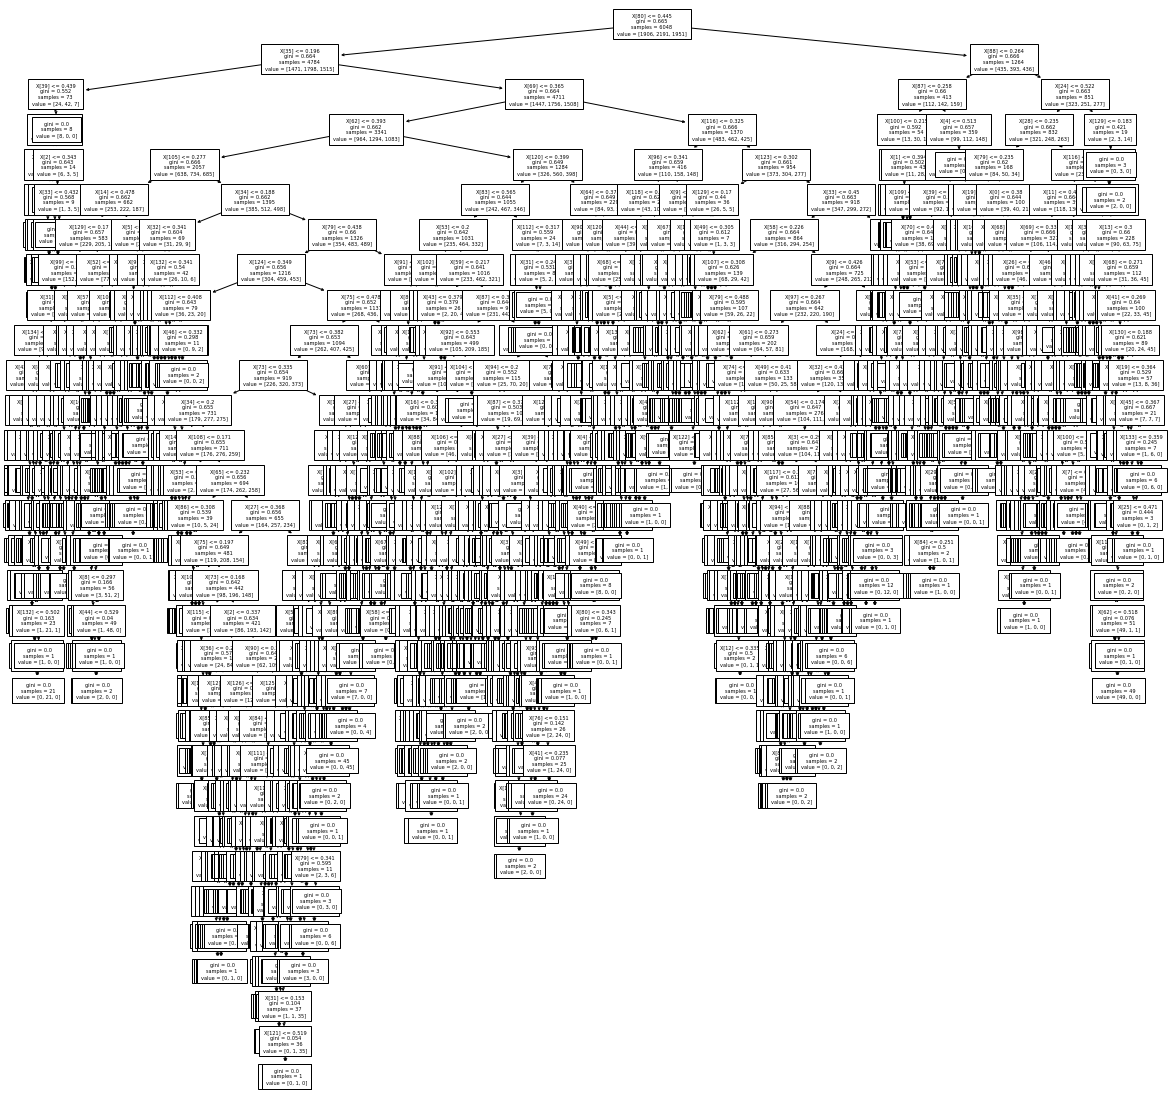

In [24]:
X = full_ML_results.drop(columns = 'Actual')
y = full_ML_results[['Actual']]
tree1 = DecisionTreeClassifier()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)
tree1.fit(xtrain, ytrain)
plt.figure(figsize = (20,20))
plot_tree(tree1, fontsize = 5)
plt.show()

In [25]:
full_ML_results.to_csv('/drive/MyDrive/new_data/ML_DF.csv')

In [26]:
full_ML_results

,92AD,92HC,92MCI,93AD,93HC,93MCI,94AD,94HC,94MCI,95AD,95HC,95MCI,96AD,96HC,96MCI,97AD,97HC,97MCI,98AD,98HC,98MCI,99AD,99HC,99MCI,100AD,100HC,100MCI,101AD,101HC,101MCI,102AD,102HC,102MCI,103AD,103HC,103MCI,104AD,104HC,104MCI,105AD,...,124AD,124HC,124MCI,125AD,125HC,125MCI,126AD,126HC,126MCI,127AD,127HC,127MCI,128AD,128HC,128MCI,129AD,129HC,129MCI,130AD,130HC,130MCI,131AD,131HC,131MCI,132AD,132HC,132MCI,Actual,meanAD,meanMCI,meanHC,maxAD,maxMCI,maxHC,minAD,minMCI,minHC,spreadAD,spreadMCI,spreadHC
0,0.226881,0.364463,0.408656,0.252036,0.264853,0.483111,0.261106,0.275795,0.463099,0.303121,0.258891,0.437988,0.279978,0.296073,0.423948,0.292416,0.297622,0.409963,0.279853,0.301739,0.418407,0.288718,0.384575,0.326707,0.392498,0.239532,0.367970,0.332179,0.357788,0.310033,0.355183,0.238221,0.406595,0.156370,0.534630,0.309000,0.349037,0.164118,0.486845,0.298682,...,0.173962,0.194813,0.631225,0.414404,0.262367,0.323229,0.396052,0.383512,0.220436,0.206558,0.271553,0.521889,0.301089,0.386799,0.312112,0.263129,0.298368,0.438502,0.410767,0.229084,0.360149,0.327246,0.245934,0.426819,0.282964,0.307362,0.409674,0,0.297950,0.398937,0.303113,0.442903,0.631225,0.534630,0.141309,0.220436,0.132435,0.301595,0.410789,0.402196
0,0.335544,0.350035,0.314421,0.240618,0.457726,0.301656,0.226976,0.482196,0.290828,0.437267,0.271255,0.291478,0.337447,0.278682,0.383872,0.273600,0.241766,0.484634,0.230622,0.292041,0.477337,0.338482,0.208626,0.452892,0.366768,0.414309,0.218922,0.370271,0.260739,0.368989,0.265539,0.395761,0.338700,0.308452,0.271023,0.420526,0.231486,0.442767,0.325748,0.326982,...,0.343442,0.262813,0.393745,0.385113,0.273333,0.341553,0.374628,0.321338,0.304034,0.355159,0.283984,0.360857,0.262815,0.232654,0.504531,0.409870,0.208655,0.381476,0.216163,0.403514,0.380324,0.279364,0.217171,0.503465,0.425036,0.279455,0.295509,1,0.315601,0.366179,0.318221,0.527379,0.586200,0.569272,0.184538,0.196281,0.208626,0.342841,0.389919,0.360646
0,0.406022,0.346012,0.247966,0.393108,0.333795,0.273098,0.462162,0.219649,0.318189,0.256805,0.326784,0.416411,0.300227,0.399930,0.299843,0.396909,0.359567,0.243524,0.317119,0.316561,0.366320,0.353597,0.319592,0.326811,0.279862,0.334979,0.385160,0.229451,0.483194,0.287354,0.449256,0.293013,0.257731,0.364239,0.298453,0.337308,0.329098,0.224174,0.446728,0.200794,...,0.553577,0.188252,0.258170,0.189398,0.485974,0.324627,0.471723,0.129259,0.399018,0.361825,0.096511,0.541664,0.179460,0.276681,0.543859,0.251497,0.245967,0.502536,0.286290,0.201280,0.512430,0.344683,0.455499,0.199818,0.373030,0.367658,0.259312,2,0.329871,0.375016,0.295113,0.588945,0.592959,0.595771,0.179460,0.191836,0.096511,0.409485,0.401123,0.499259
0,0.394586,0.228308,0.377107,0.268782,0.463527,0.267691,0.298105,0.220607,0.481287,0.434364,0.239812,0.325824,0.335964,0.255701,0.408335,0.326075,0.255131,0.418794,0.323350,0.161265,0.515384,0.326388,0.348596,0.325015,0.299974,0.225560,0.474466,0.185496,0.418126,0.396378,0.446771,0.301542,0.251686,0.348758,0.221918,0.429324,0.381209,0.317283,0.301508,0.311912,...,0.272887,0.517509,0.209604,0.197286,0.389899,0.412815,0.388968,0.265819,0.345213,0.251672,0.342295,0.406033,0.346103,0.288590,0.365307,0.225056,0.471040,0.303905,0.330886,0.298453,0.370661,0.378116,0.291092,0.330792,0.454920,0.388388,0.156692,2,0.315165,0.374065,0.310770,0.454920,0.591229,0.517509,0.161527,0.156692,0.159207,0.293393,0.434538,0.358302
0,0.313203,0.281335,0.405462,0.180916,0.503903,0.315181,0.324804,0.324258,0.350938,0.293225,0.325926,0.380848,0.267143,0.333066,0.399791,0.360620,0.285442,0.353938,0.426202,0.386422,0.187377,0.395585,0.387910,0.216505,0.384461,0.304343,0.311196,0.392562,0.265697,0.341741,0.505541,0.291079,0.203380,0.407885,0.186480,0.405635,0.151017,0.384919,0.464064,0.363752,...,0.359230,0.249788,0.390982,0.382424,0.292844,0.324732,0.315070,0.369432,0.315497,0.181809,0.440124,0.378067,0.299100,0.198690,0.502210,0.327864,0.305081,0.367054,0.404329,0.248022,0.347649,0.311823,0.192293,0.495884,0.330052,0.270773,0.399175,1,0.345737,0.35

In [8]:
SPLITS = 20
label_encoder  = LabelEncoder()

In [9]:
FINAL_MODEL_STR = 'transformer'+str(SPLITS-1)
FINAL_MODEL_PATH = '/drive/MyDrive/models/'+FINAL_MODEL_STR+'.pt'
final_model = torch.load(FINAL_MODEL_PATH)

test_data = pd.read_csv('/drive/MyDrive/new_data/test.csv')

In [10]:
# inv_mapping = {v: k for k, v in mapping.items()}

In [11]:
test_data

,Unnamed: 0,MRI_ID,Subject,cdr
0,29,/drive/MyDrive/oasis_original/OAS30008_Freesur...,OAS30008,HC
1,30,/drive/MyDrive/oasis_original/OAS30008_Freesur...,OAS30008,HC
2,31,/drive/MyDrive/oasis_original/OAS30008_Freesur...,OAS30008,HC
3,32,/drive/MyDrive/oasis_original/OAS30008_Freesur...,OAS30008,HC
4,35,/drive/MyDrive/oasis_original/OAS30010_Freesur...,OAS30010,HC
...,...,...,...,...
234,1792,/drive/MyDrive/oasis_original/OAS31152_Freesur...,OAS31152,AD
235,1808,/drive/MyDrive/oasis_original/OAS31160_Freesur...,OAS31160,HC
236,1811,/drive/MyDrive/oasis_original/OAS31162_Freesur...,OAS31162,MCI
237,1812,/drive/MyDrive/oasis_original/OAS31163_Freesur...,OAS31163,MCI


In [25]:
test_data.groupby('cdr').count()

,Unnamed: 0,MRI_ID,Subject
cdr,,,
AD,22,22,22
HC,171,171,171
MCI,46,46,46


In [12]:
# admci_test = test_data[test_data['cdr'] != 'HC']
# hc_test = test_data[test_data['cdr'] == 'HC']
# test_data = pd.concat([admci_test, hc_test])
# test_data

In [13]:
inv_mapping = {0:'AD', 1:'HC', 2:'MCI'}

In [14]:
test_HC, test_MCI, test_AD = return_scan_paths(test_data, 'test')

MRI scans of AD cases in test data: 22
MRI scans of MCI cases in test data: 46
MRI scans of HC cases in test data: 171


In [15]:
x_test = np.array([process_scan(path) for path in tqdm(test_HC)])
x_test = np.concatenate((x_test, np.array([process_scan(path) for path in tqdm(test_MCI)])))
x_test = np.concatenate((x_test, np.array([process_scan(path) for path in tqdm(test_AD)])))

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [16]:
y_test = return_labels(test_data)
y_test = [item for sublist in y_test for item in sublist]
y_test = np.array(label_encoder.fit_transform(y_test))
tens_x_test = torch.Tensor(x_test)
tens_y_test = torch.Tensor(y_test)
test_ds2 = TensorDataset(tens_x_test, tens_y_test)

In [17]:
full_ML_results = pd.read_csv('/drive/MyDrive/new_data/ML_DF.csv').drop(columns = 'Unnamed: 0')
X = full_ML_results.drop(columns = 'Actual')
y = full_ML_results[['Actual']]
tree1 = DecisionTreeClassifier()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)
tree1.fit(xtrain, ytrain)
# plt.figure(figsize = (20,20))
# plot_tree(tree1, fontsize = 5)
# plt.show()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
xtrain

,92AD,92HC,92MCI,93AD,93HC,93MCI,94AD,94HC,94MCI,95AD,95HC,95MCI,96AD,96HC,96MCI,97AD,97HC,97MCI,98AD,98HC,98MCI,99AD,99HC,99MCI,100AD,100HC,100MCI,101AD,101HC,101MCI,102AD,102HC,102MCI,103AD,103HC,103MCI,104AD,104HC,104MCI,105AD,...,123MCI,124AD,124HC,124MCI,125AD,125HC,125MCI,126AD,126HC,126MCI,127AD,127HC,127MCI,128AD,128HC,128MCI,129AD,129HC,129MCI,130AD,130HC,130MCI,131AD,131HC,131MCI,132AD,132HC,132MCI,meanAD,meanMCI,meanHC,maxAD,maxMCI,maxHC,minAD,minMCI,minHC,spreadAD,spreadMCI,spreadHC
2981,0.465076,0.170243,0.364680,0.200760,0.560475,0.238765,0.473721,0.190744,0.335535,0.339183,0.287827,0.372991,0.572046,0.233497,0.194457,0.207648,0.415587,0.376765,0.265880,0.207302,0.526818,0.409803,0.171322,0.418876,0.368613,0.258729,0.372658,0.250490,0.383835,0.365675,0.244812,0.208111,0.547076,0.210655,0.323414,0.465931,0.267214,0.300971,0.431815,0.374932,...,0.455710,0.395407,0.387977,0.216616,0.376012,0.274331,0.349656,0.403929,0.284502,0.311569,0.452273,0.368594,0.179134,0.406266,0.345596,0.248138,0.288311,0.284438,0.427250,0.238389,0.333113,0.428499,0.351492,0.335974,0.312533,0.256825,0.395865,0.347309,0.331899,0.360006,0.308095,0.572046,0.547076,0.560475,0.200760,0.179134,0.170243,0.371286,0.367943,0.390232
7095,0.257255,0.288488,0.454257,0.270132,0.342112,0.387755,0.261384,0.330454,0.408162,0.216480,0.443133,0.340387,0.461574,0.316354,0.222071,0.316071,0.540346,0.143583,0.245463,0.378200,0.376337,0.235140,0.405248,0.359613,0.262259,0.285976,0.451765,0.357981,0.166615,0.475404,0.502799,0.288876,0.208324,0.258276,0.314799,0.426925,0.285769,0.471569,0.242662,0.153344,...,0.482224,0.246231,0.463261,0.290508,0.234182,0.421784,0.344033,0.236964,0.291497,0.471539,0.238573,0.324252,0.437175,0.279572,0.361518,0.358910,0.263313,0.215266,0.521422,0.279113,0.285181,0.435706,0.179271,0.445422,0.375307,0.332193,0.292089,0.375718,0.289318,0.370284,0.340398,0.502799,0.521422,0.546087,0.153344,0.143583,0.166615,0.349455,0.377839,0.379472
3832,0.286843,0.347635,0.365522,0.435667,0.237023,0.327310,0.291787,0.358303,0.349909,0.303543,0.303830,0.392627,0.213762,0.312100,0.474139,0.263179,0.322652,0.414169,0.302933,0.337503,0.359564,0.226397,0.368970,0.404633,0.522138,0.143206,0.334657,0.264381,0.159290,0.576328,0.253095,0.397637,0.349268,0.209015,0.303659,0.487326,0.334963,0.236835,0.428202,0.299729,...,0.358729,0.340088,0.396497,0.263415,0.315918,0.304051,0.380031,0.365103,0.220270,0.414628,0.291620,0.315340,0.393040,0.279721,0.206694,0.513585,0.500757,0.243334,0.255908,0.269259,0.315899,0.414843,0.298270,0.301222,0.400508,0.318794,0.317420,0.363786,0.308920,0.386740,0.304340,0.522138,0.576328,0.624190,0.169924,0.198541,0.143206,0.352214,0.377788,0.480984
3095,0.423306,0.290370,0.286324,0.415514,0.293248,0.291239,0.260027,0.416369,0.323604,0.255595,0.415596,0.328809,0.312293,0.343615,0.344092,0.276356,0.355387,0.368257,0.318740,0.275871,0.405390,0.340534,0.399580,0.259886,0.194066,0.382196,0.423738,0.371946,0.256623,0.371431,0.269056,0.291882,0.439061,0.252409,0.407988,0.339603,0.334032,0.346687,0.319281,0.348018,...,0.322104,0.231166,0.311898,0.456935,0.342368,0.433930,0.223702,0.292591,0.359996,0.347412,0.212695,0.245917,0.541388,0.394712,0.329840,0.275447,0.338839,0.358098,0.303063,0.304143,0.373301,0.322556,0.310221,0.406155,0.283624,0.194082,0.188335,0.617583,0.315706,0.360468,0.323826,0.471086,0.617583,0.433930,0.194066,0.223702,0.188335,0.277021,0.393881,0.245595
563,0.262967,0.343935,0.393098,0.373261,0.417111,0.209628,0.533181,0.196559,0.270260,0.162208,0.354342,0.483450,0.407926,0.201953,0.390120,0.342995,0.352684,0.304321,0.410765,0.273095,0.316140,0.401733,0.247294,0.350972,0.264172,0.407185,0.328642,0.263785,0.315225,0.420990,0.237471,0.275561,0.486968,0.412160,0.245428,0.342411,0.303018,0.269455,0.427528,0.429404,...,0.599587,0.240978,0.257591,0.501431,0.372160,0.276087,0.351753,0.351571,0.406274,0.242155,0.467626,0.290029,0.242345,0.316139,0.216884,0.466977,0.385922,0.258387,0.355691,0.445406,0.284582,0.270013,0.238647,0.343599,

In [19]:
ytrain

,Actual
2981,1
7095,0
3832,0
3095,1
563,1
...,...
412,0
4875,1
6584,0
3545,0


In [20]:
Counter(ytrain['Actual'])

Counter({0: 1903, 1: 2180, 2: 1965})

In [21]:
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-384')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    final_model.cuda() 

EVAL_BATCH = 1
eval_loader  = data.DataLoader(test_ds2, batch_size=EVAL_BATCH, shuffle=True, num_workers=1) 
preds = []
actual = []
final_preds = []
with torch.no_grad():
  for step, (x,y) in enumerate(eval_loader): 
    probs_arr = []

    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    results_temp = pd.DataFrame()

    for slic in range(112-20,112+21):
      new_x = x[:,:,:,slic]
      new_x = Image.fromarray(np.array(new_x).astype('uint8'), 'RGB')
      new_x = torch.tensor(np.stack(feature_extractor(new_x)['pixel_values'], axis=0))
      new_x = new_x.to(device)
      y = y.to(device).long()
      prediction, loss = final_model(new_x, y)
      predicted_probs = tf.nn.softmax(prediction.cpu().detach().numpy())

      col_name_ad = str(slic) + 'AD'
      col_name_hc = str(slic) + 'HC'
      col_name_mci = str(slic) + 'MCI'

      temp_df = pd.DataFrame([predicted_probs[0]], columns =[col_name_ad, col_name_hc, col_name_mci], dtype = float)
      results_temp = pd.concat([results_temp, temp_df], axis = 1)

    results_temp['meanAD'] = results_temp.filter(like='AD').mean(axis = 1)
    results_temp['meanMCI'] = results_temp.filter(like='MCI').mean(axis = 1)
    results_temp['meanHC'] = results_temp.filter(like='HC').mean(axis = 1)

    results_temp['maxAD'] = results_temp.filter(like='AD').max(axis = 1)
    results_temp['maxMCI'] = results_temp.filter(like='MCI').max(axis = 1)
    results_temp['maxHC'] = results_temp.filter(like='HC').max(axis = 1)

    results_temp['minAD'] = full_ML_results.filter(like='AD').min(axis = 1)
    results_temp['minMCI'] = full_ML_results.filter(like='MCI').min(axis = 1)
    results_temp['minHC'] = full_ML_results.filter(like='HC').min(axis = 1)

    results_temp['spreadAD'] = results_temp['maxAD'] - results_temp['minAD']
    results_temp['spreadMCI'] = results_temp['maxMCI'] - results_temp['minMCI']
    results_temp['spreadHC'] = results_temp['maxHC'] - results_temp['minHC']

    prediction = tree1.predict(results_temp)[0]
    preds.append(prediction)
    actual.append(y.item())
    print(f'Prediction: {prediction} - Actual target: {inv_mapping[y.item()]}')

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Prediction: 1 - Actual target: HC
Prediction: 2 - Actual target: MCI
Prediction: 1 - Actual target: HC
Prediction: 0 - Actual target: AD
Prediction: 0 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 0 - Actual target: MCI
Prediction: 0 - Actual target: HC
Prediction: 0 - Actual target: MCI
Prediction: 1 - Actual target: HC
Prediction: 0 - Actual target: MCI
Prediction: 2 - Actual target: HC
Prediction: 2 - Actual target: MCI
Prediction: 2 - Actual target: HC
Prediction: 0 - Actual target: HC
Prediction: 1 - Actual target: AD
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 0 - Actual target: HC
Prediction: 2 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 0 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Prediction: 1 - Actual target: HC
Predictio

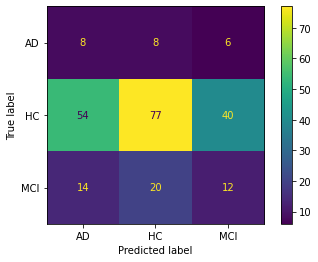

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix(actual, preds), display_labels = ['AD', 'HC', 'MCI'])
disp.plot()

In [23]:
print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.11      0.36      0.16        22
           1       0.73      0.45      0.56       171
           2       0.21      0.26      0.23        46

    accuracy                           0.41       239
   macro avg       0.35      0.36      0.32       239
weighted avg       0.57      0.41      0.46       239



In [24]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(actual, preds)

0.025498191006719018

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(actual, preds)

0.40585774058577406